# __Exchange Rate__

# 1 Abstract

This project aims to predict hotel booking cancellations, a challenge that significantly affects hotel profitability and operational efficiency. We use a dataset encompassing booking-related factors and weather data to identify key predictors for cancellations. Multiple machine learning models, including Logistic Regression, Neural Network, Decision Tree, and SARIMA for time-series analysis, were developed to explore the prediction accuracy. Additionally, an ensemble model combined predictions from various models to improve overall accuracy. The ensemble model outperformed individual models with an accuracy of 82.86%, precision of 82.76%, recall of 82.86%, and AUC score of 0.8145. This predictive model provides valuable insights that hotels can leverage to mitigate the negative impact of cancellations and enhance profitability through improved revenue management.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error,make_scorer, r2_score, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 2 Introduction 

In this project, we aim to create a predictive model that can be used to accurately predict whether a hotel reservation will be canceled. This is important for hotels because canceled bookings can severely impact a hotel's revenue and related operational strategies. Accurate information about room reservations is key to decrease the hotel losses, such as the profit loss of last-minute cancellations. Whether a hotel receives advance notice or not, these cancellations result in vacancies in their booked rooms that could have been re-rented to others. However when cancellations are received at the last minute, which can make it difficult to schedule re-released rooms. 

The negative impact of cancellations includes not only the loss of revenue from these vacant rooms, but also the additional costs associated with the distribution channel for re-booking, as well as lower profit margins due to having to sell the rooms at a reduced price at the last minute. However, by accurately predicting cancellations and taking steps that can effectively decrease the negative impact of cancellations, hotels can improve profitability and operational efficiency. We utilize a dataset containing a wide range of booking-related factors to provide valuable insights for hotel management. Our goal is to build a robust model that helps hotels refine their operational processes and maximize the revenue.

### 2.3 Data to be Used

**USD to EUR Exchange Rates Dataset:**

Contains two columns: DATE and DEXUSEU.
DATE ranges from January 1999 to the latest available date, with data points sampled daily. 


In [2]:
exchange_rate = pd.read_csv("https://raw.githubusercontent.com/Zhengnan817/SNP/main/Exchange_rate/src/DEXUSEU.csv")
display(exchange_rate.shape)
exchange_rate.head(5)

(6650, 2)

,Timeseries,DEXUSEU
0,1999/1/4,1.1812
1,1999/1/5,1.176
2,1999/1/6,1.1636
3,1999/1/7,1.1672
4,1999/1/8,1.1554


In [3]:
exchange_rate.describe()

,Timeseries,DEXUSEU
count,6650,6650
unique,6650,3701
top,1999/1/4,.
freq,1,256


# 3 Explanatory Data Analysis

First define the functions and variable names to be used for EDA.

- __'Lead_time':__  
    The data is heavily left skewed, having most value on 0. 
- __'arrival_date_year','arrival_date_week_number','arrival_date_day_of_month', 'total_of_special_requests','reservation_status_date':__  
    The data is roughly evenly distributed.
- __'stays_in_weekend_nights','stays_in_week_nights','adults','children','babies','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr','required_car_parking_spaces':__   
    These variables has most value on the lower side, indicating a potential outliers of extreme value.

Categorical variables such as country, agent and company has too many categories and most of them are null values.  
There are undefined category in __'meal', 'distribution_channel'__.  
__'Reservation_status'__ has a risk of data leaking.

# 4 Data Preparation

### 4.1 Missing value
There are 3.8% missing values in dataset. The missing values ​​seem to be relatively evenly distributed and there are no long-term continuous missing values, which means that most of the missing values ​​are surrounded by relatively recent data points. And the exchange rate data of the next day is highly correlated with the previous day, so we choose to fill in the data forward, which is simple and can maintain the continuity of the data in most cases.

In [4]:
exchange_rate['DEXUSEU'] = exchange_rate['DEXUSEU'].replace('.', pd.NA)
exchange_rate['DEXUSEU'] = pd.to_numeric(exchange_rate['DEXUSEU'], errors='coerce')

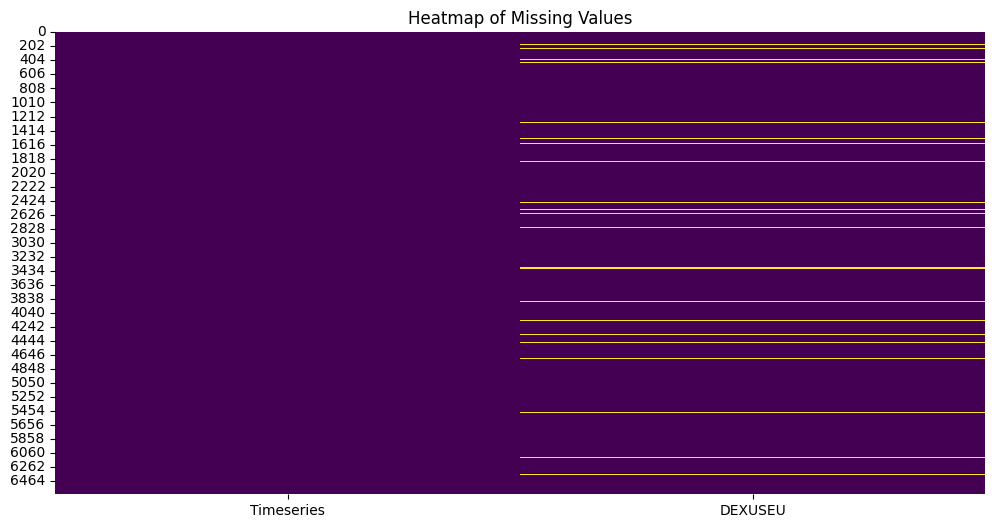

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(exchange_rate.isnull(), cbar=False, cmap='viridis') # Remove parentheses and use .isnull()
plt.title('Heatmap of Missing Values')
plt.show()

In [6]:
missing_values_count = exchange_rate.isnull().sum()
total_values_count = exchange_rate.shape[0]
missing_percentage = (missing_values_count / total_values_count) * 100

print("Missing values percentage in exchange_rate_dataset:")
print(missing_percentage)

Missing values percentage in exchange_rate_dataset:
Timeseries    0.000000
DEXUSEU       3.849624
dtype: float64


In [7]:
# forward 
df_filled = exchange_rate.fillna(method='ffill')

In [8]:
df_filled

,Timeseries,DEXUSEU
0,1999/1/4,1.1812
1,1999/1/5,1.1760
2,1999/1/6,1.1636
3,1999/1/7,1.1672
4,1999/1/8,1.1554
...,...,...
6645,2024/6/24,1.0727
6646,2024/6/25,1.0705
6647,2024/6/26,1.0682
6648,2024/6/27,1.0708


In [9]:
missing_values_count = df_filled.isnull().sum()
total_values_count = df_filled.shape[0]
missing_percentage = (missing_values_count / total_values_count) * 100

print("Missing values percentage in exchange_rate_dataset:")
print(missing_percentage)

Missing values percentage in exchange_rate_dataset:
Timeseries    0.0
DEXUSEU       0.0
dtype: float64


### 4.2 Outliers
There is no outliers

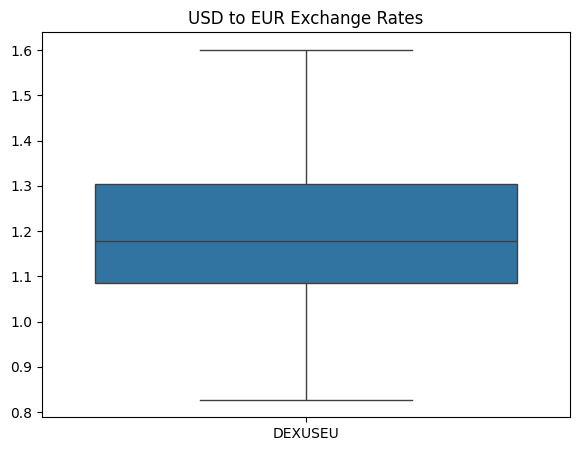

In [10]:
# prompt: boxplots for both the datasets

# Boxplots for both datasets
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
sns.boxplot(data=df_filled)
plt.title('USD to EUR Exchange Rates')

plt.show()

# 5. Prepped Data Overview

In [11]:
df_filled['Timeseries'] = pd.to_datetime(df_filled['Timeseries'])

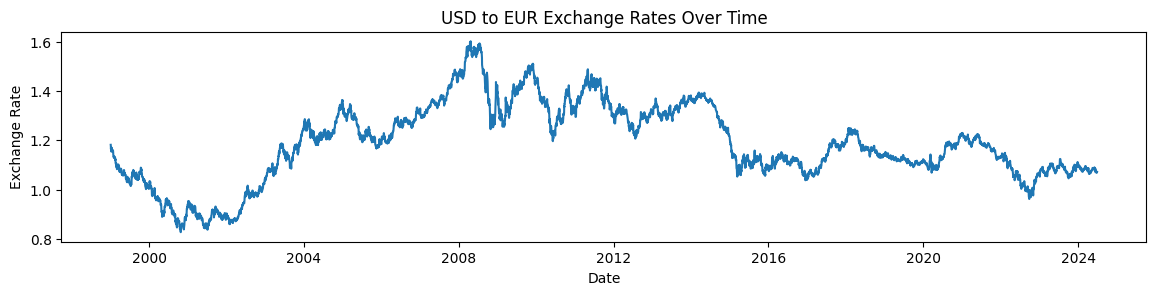

In [12]:

plt.figure(figsize=(14, 6))

# USD to EUR Exchange Rates Time Series
plt.subplot(2, 1, 2)
plt.plot(df_filled['Timeseries'], df_filled['DEXUSEU'])
plt.title("USD to EUR Exchange Rates Over Time")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')


plt.show()

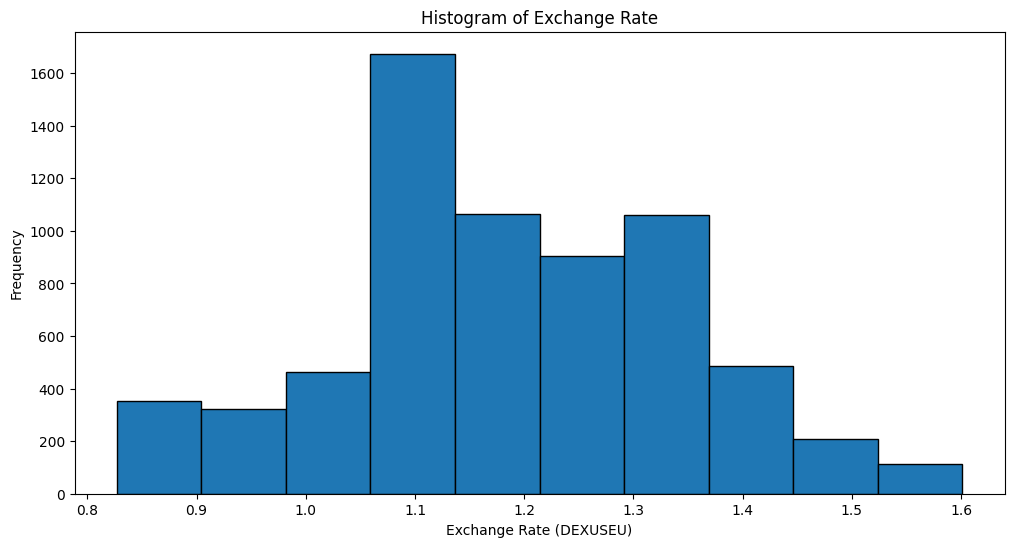

In [13]:
plt.figure(figsize=(12, 6))
plt.hist(df_filled['DEXUSEU'], bins=10, edgecolor='black')
plt.xlabel('Exchange Rate (DEXUSEU)')
plt.ylabel('Frequency')
plt.title('Histogram of Exchange Rate')
plt.show()

# 6. ARIMA & Machine Learning Models

### 6.1 ARIMA Model

#### 6.1.1 Daily ARIMA

- Time Series Transformation

In order to better help Hotel manage the bookings and make a schedule of the future hotel Resources. We use time series and SARIMA model to do the prediction. We set the datetime as the time series and count the numbers of the bookings from 2015-7 to 2017-10.

In [14]:
df_filled.set_index('Timeseries', inplace=True)

In [15]:
print(df_filled.describe())

           DEXUSEU
count  6650.000000
mean      1.186455
std       0.156422
min       0.827000
25%       1.085400
50%       1.177850
75%       1.305075
max       1.601000


- Seasonal Decompose

We used seasonal_decompose to observe the trend, seasonal changes and its residuals, and finally determined that a period of 30 can produce better seasonal changes.

__Trend:__ The trend component shows the long-term trend of the time series. From the figure, we can see that the trend is relatively stable overall, but there are slight fluctuations.  

__Seasonal:__ The seasonal component reveals the periodic fluctuations of the data, which are repeated patterns with fixed frequency and amplitude. From the figure, the seasonal changes are very regular, suggesting that we consider seasonal components in the model. 

__Residual:__ The residual component shows the random fluctuations after removing the trend and seasonality. The fluctuations in the residual graph are relatively random, which is an ideal state, indicating that the model has captured the trend and seasonality in the data well.

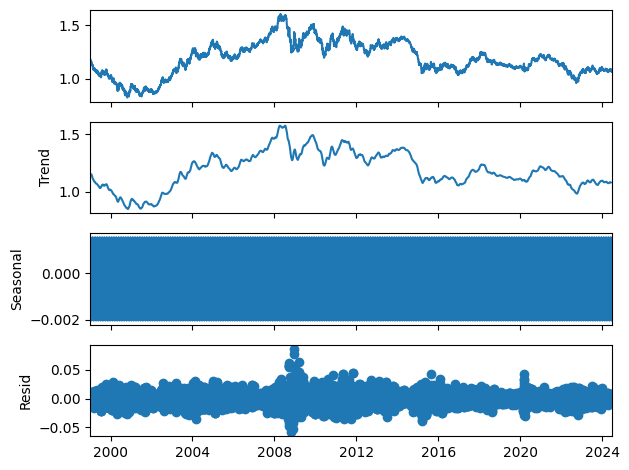

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
daily_seasonal = seasonal_decompose(df_filled, model='additive', period=30)

# Plot the results
fig = daily_seasonal.plot()
plt.show()

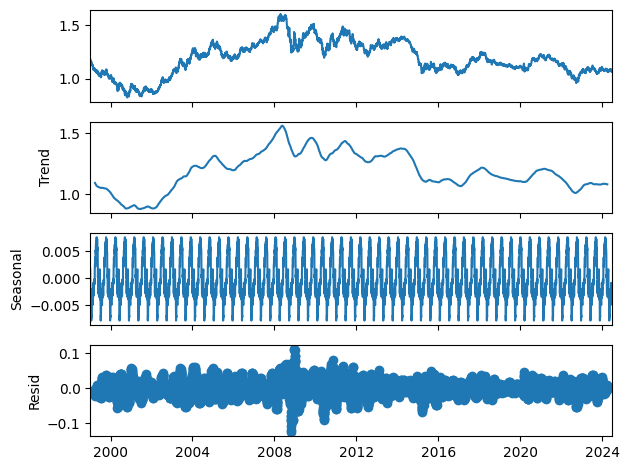

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
daily_seasonal = seasonal_decompose(df_filled, model='additive', period=120)

# Plot the results
fig = daily_seasonal.plot()
plt.show()

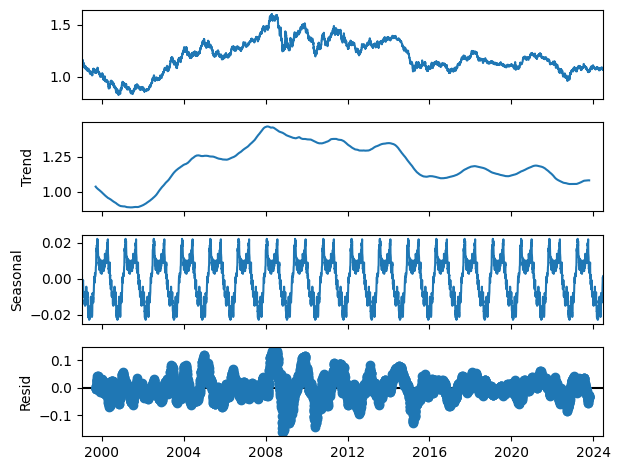

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
daily_seasonal = seasonal_decompose(df_filled, model='additive', period=360)

# Plot the results
fig = daily_seasonal.plot()
plt.show()

Next, let's check whether the data is stable. We can use adfuller function to do the ADF stationarity test. The result shows that the p-value is over 0.05. So we need to apply first-order differencing and check the stationarity of the resulting data.

- ADF

In [19]:
# Perform ADF stationarity test
from statsmodels.tsa.stattools import adfuller
daily_ADF = adfuller(df_filled)
print('ADF Statistic: %f' % daily_ADF[0])
print('p-value: %f' % daily_ADF[1])

ADF Statistic: -1.723032
p-value: 0.419287


In [20]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_filled)
# Check p-Values and confidence interval
if result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")

Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


In [21]:
data_log = np.log(df_filled['DEXUSEU'])  # 对数变换
result = adfuller(data_log)  # 对数变换后的ADF测试

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.676645
p-value: 0.443184
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [22]:
# Perform first differencing on the data
exchange_rate_diff = data_log.diff().dropna()

# Repeat the ADF test
result_diff = adfuller(exchange_rate_diff)
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -80.692665
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [23]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(exchange_rate_diff)
# Check p-Values and confidence interval
if result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")

Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


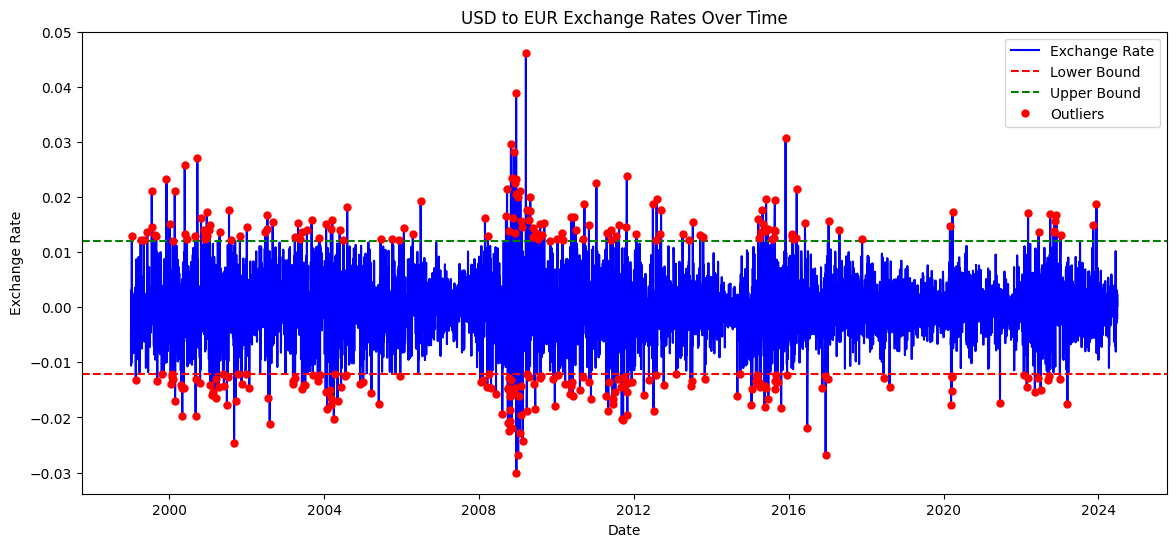

In [24]:
# 计算IQR和四分位数
# 计算IQR
Q1 = exchange_rate_diff.quantile(0.25)
Q3 = exchange_rate_diff.quantile(0.75)
IQR = Q3 - Q1

# 计算异常值界限
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# 绘制时间序列数据
plt.plot(exchange_rate_diff, label='Exchange Rate', color='blue')

# 添加异常值的界限线
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='g', linestyle='--', label='Upper Bound')

# 标记异常值
outliers = (exchange_rate_diff < lower_bound) | (exchange_rate_diff > upper_bound)
plt.plot(exchange_rate_diff[outliers], 'ro', markersize=5, label='Outliers')

plt.title("USD to EUR Exchange Rates Over Time")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()

plt.show()


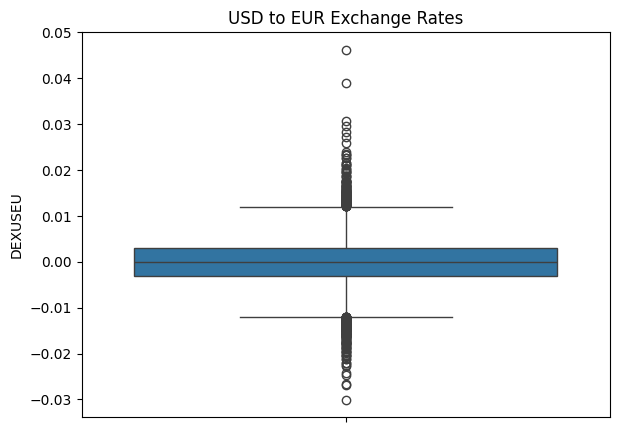

In [25]:
# prompt: boxplots for both the datasets

# Boxplots for both datasets
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 2)
sns.boxplot(data=exchange_rate_diff)
plt.title('USD to EUR Exchange Rates')

plt.show()

In [26]:
Q1 = exchange_rate_diff.quantile(0.25)
Q3 = exchange_rate_diff.quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的条件
outliers = ((exchange_rate_diff < (Q1 - 1.5 * IQR)) | (exchange_rate_diff > (Q3 + 1.5 * IQR)))
outlier_count = outliers.sum()

print("Number of outliers:", outlier_count)

Number of outliers: 322


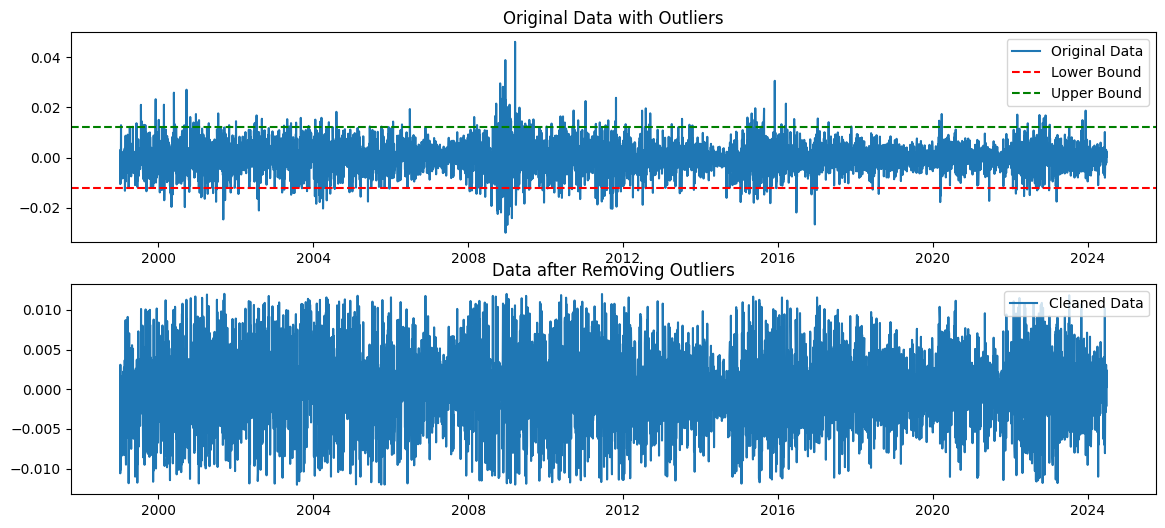

Original data size: 6649
Cleaned data size: 6327


In [27]:
# 去除异常值
cleaned_data = exchange_rate_diff[~outliers]

# 比较去除前后的数据分布
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(exchange_rate_diff, label='Original Data')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Lower Bound')
plt.axhline(y=upper_bound, color='g', linestyle='--', label='Upper Bound')
plt.title("Original Data with Outliers")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(cleaned_data, label='Cleaned Data')
plt.title("Data after Removing Outliers")
plt.legend()

plt.show()

# 输出去除前后的数据大小对比
print("Original data size:", len(exchange_rate_diff))
print("Cleaned data size:", len(cleaned_data))

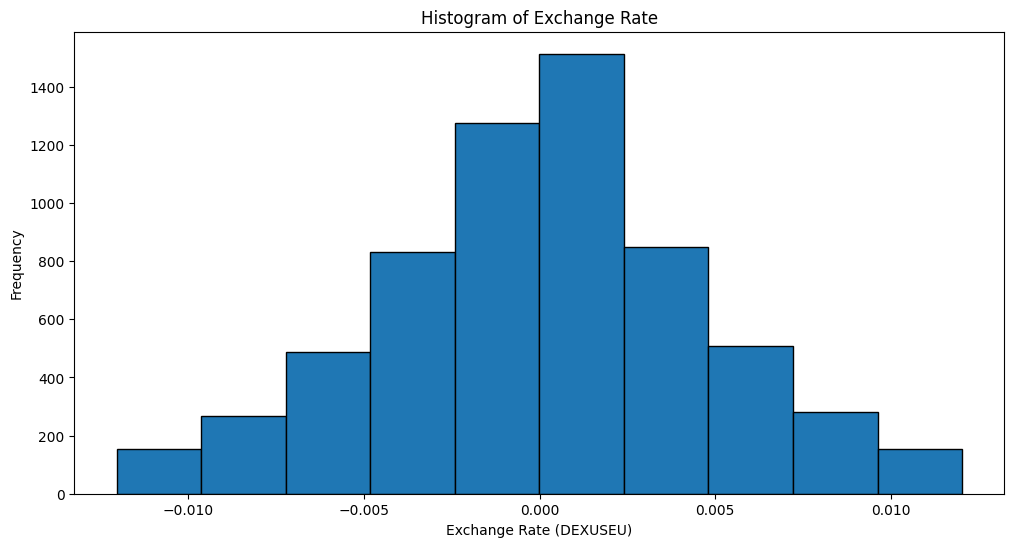

In [28]:
plt.figure(figsize=(12, 6))
plt.hist(cleaned_data, bins=10, edgecolor='black')
plt.xlabel('Exchange Rate (DEXUSEU)')
plt.ylabel('Frequency')
plt.title('Histogram of Exchange Rate')
plt.show()

- ACF & PACF

Next, Let's use ACF and PACF plot to decide the p, d, q and P, D, Q, M values.

__Non-seasonal parameters:__  
__p=0__ (AR order): As the PACF plot shows the first lag is insignificance, set p=0.  
__d=1__ (Differencing order): Given that the trend component of the original data is relatively stable and has been differenced, set d=1.  
__q=0__ (MA order): The ACF plot shows insignificance at the first lag, therefore set q=0.  

__Seasonal parameters:__  
__P=0__ (Seasonal AR order): The seasonal PACF does not show significant truncation or tailing.  
__D=1__(Seasonal differencing order): To ensure the stationarity of the seasonal component.  
__Q=0__ (Seasonal MA order): The seasonal ACF does not indicates a seasonal pattern.  
__M=30__ (Period): Our cycle essentially reflects an annual repetition, but setting it to 365 is too large, so we use 30 to start modeling. 


In [29]:
total_length = len(cleaned_data)
train_end = int(total_length * 0.7)
validation_end = int(total_length * 0.9)  # 70% + 20% = 90% 

# 分割数据集
train_data = cleaned_data.iloc[:train_end]
validation_data = cleaned_data.iloc[train_end:validation_end]
test_data = cleaned_data.iloc[validation_end:]

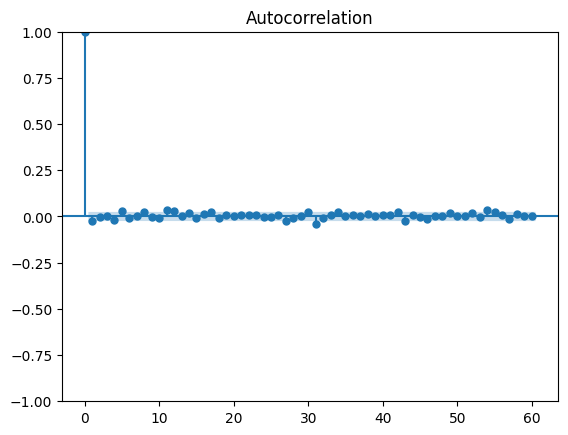

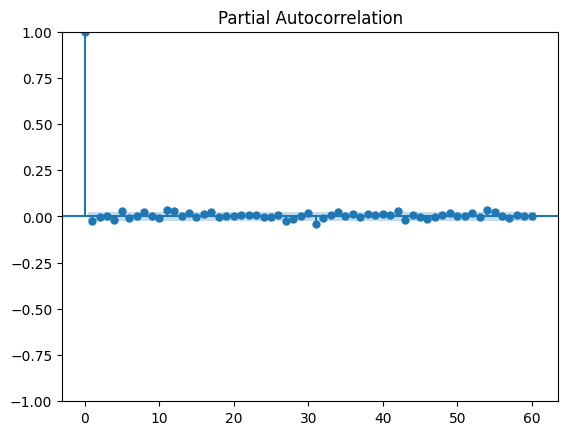

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(cleaned_data, lags=60)
plot_pacf(cleaned_data, lags=60)
plt.show()

In [31]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# 假设df_filled是你的DataFrame，其中已经处理好了时间序列数据
results = []

# 尝试不同的模型配置
for p in range(10):  # AR的可能阶数
    for d in range(1):  # 差分阶数
        for q in range(1):  # MA的可能阶数
            try:
                model = ARIMA(train_data, order=(p,d,q))
                result = model.fit()
                results.append((p, d, q, result.aic, result.bic))
            except:
                continue

# 将结果转换成DataFrame以便更好地观察
result_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'AIC', 'BIC'])

# 查看AIC和BIC最小的模型
best_aic = result_df[result_df.AIC == result_df.AIC.min()]
best_bic = result_df[result_df.BIC == result_df.BIC.min()]

print("Best AIC models:\n", best_aic)
print("Best BIC models:\n", best_bic)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

Best AIC models:
    p  d  q           AIC           BIC
1  1  0  0 -34563.336807 -34544.149697
Best BIC models:
    p  d  q           AIC           BIC
0  0  0  0 -34559.834557 -34547.043151


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(10, 0, 0))
model_fit = model.fit()

print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                DEXUSEU   No. Observations:                 4428
Model:                ARIMA(10, 0, 0)   Log Likelihood               17288.927
Date:                Mon, 08 Jul 2024   AIC                         -34553.855
Time:                        19:32:42   BIC                         -34477.106
Sample:                             0   HQIC                        -34526.790
                               - 4428                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.393e-05   7.44e-05      0.456      0.648      -0.000       0.000
ar.L1         -0.0355      0.015     -2.342      0.019      -0.065      -0.006
ar.L2          0.0007      0.015      0.051      0.9

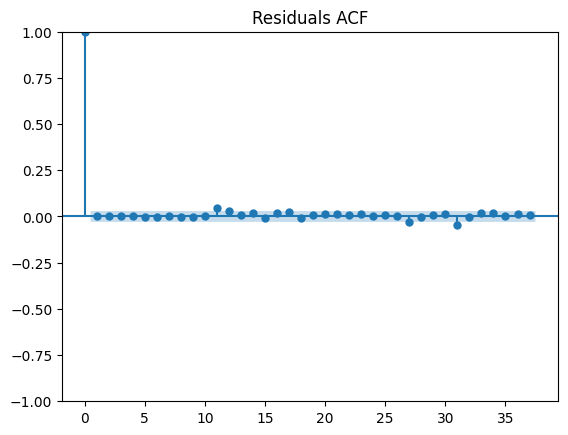

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

# 拟合模型后获取残差
residuals = model_fit.resid

# 绘制残差的自相关图
plot_acf(residuals)
plt.title('Residuals ACF')
plt.show()


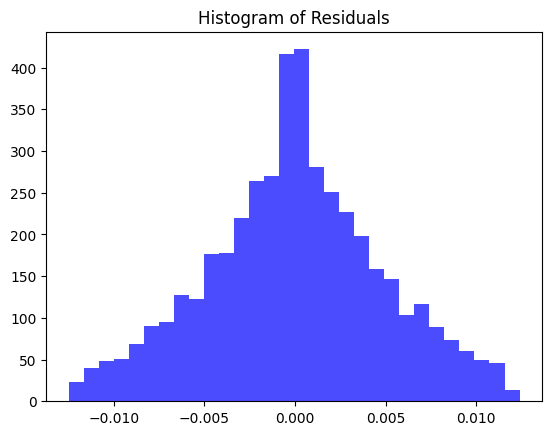

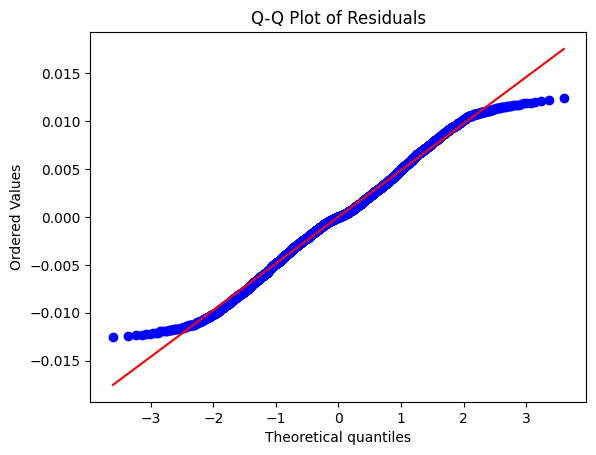

In [34]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 绘制残差的直方图
plt.hist(residuals, bins=30, alpha=0.7, color='b')
plt.title('Histogram of Residuals')
plt.show()

# 绘制Q-Q图
fig = plt.figure()
res = stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


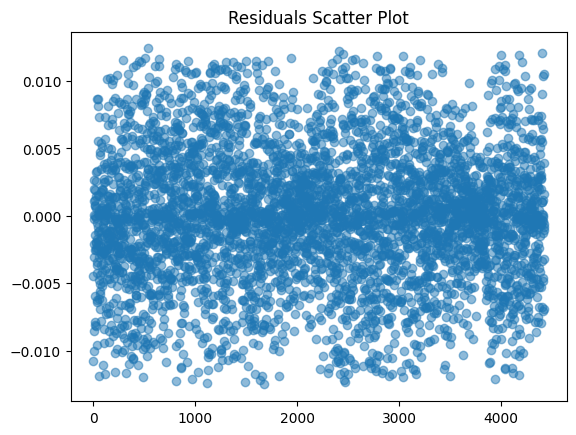

In [35]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS

# 绘制残差散点图
plt.scatter(x=np.arange(len(residuals)), y=residuals, alpha=0.5)
plt.title('Residuals Scatter Plot')
plt.show()

In [36]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 进行Ljung-Box测试
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)


    lb_stat  lb_pvalue
10  0.04716        1.0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


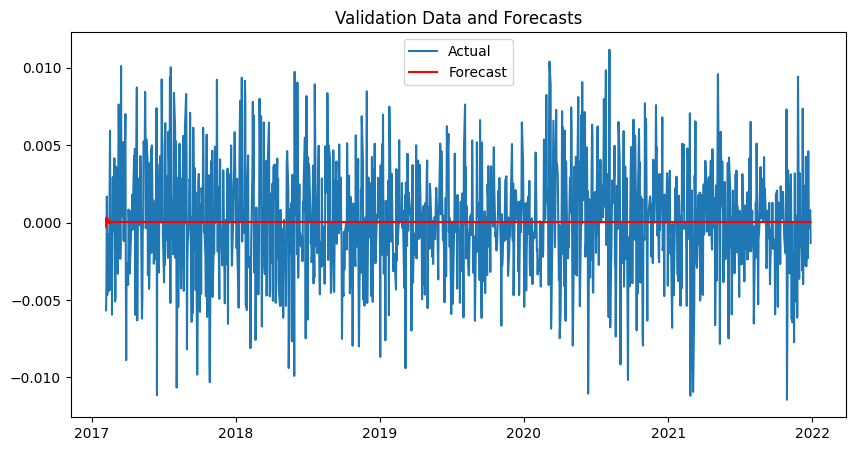

In [37]:
validation_predictions = model_fit.forecast(steps=len(validation_data))

# 可视化预测与实际数据
plt.figure(figsize=(10, 5))
plt.plot(validation_data.index, validation_data, label='Actual')
plt.plot(validation_data.index, validation_predictions, label='Forecast', color='red')
plt.title('Validation Data and Forecasts')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


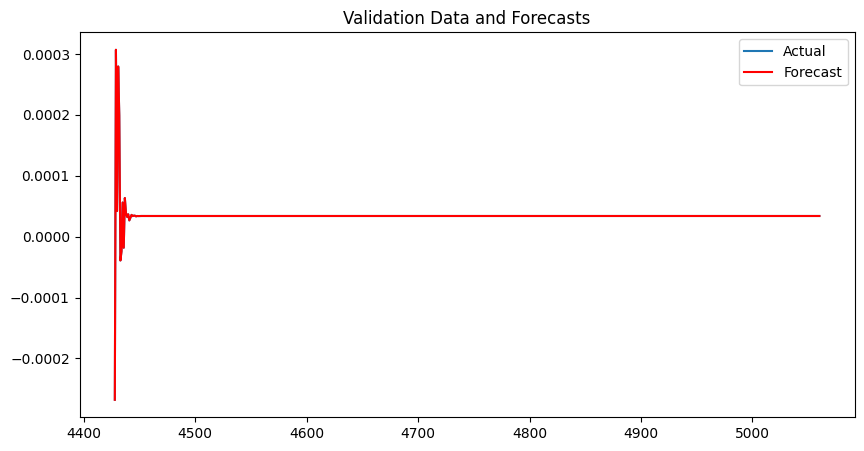

In [38]:
test_predictions = model_fit.forecast(steps=len(test_data))

# 可视化预测与实际数据
plt.figure(figsize=(10, 5))
plt.plot(test_predictions.index, test_predictions, label='Actual')
plt.plot(test_predictions.index, test_predictions, label='Forecast', color='red')
plt.title('Validation Data and Forecasts')
plt.legend()
plt.show()

### 6.1.2 Daily SARIMAX Model

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build and fit the SARIMA model
sarima_model_daily = SARIMAX(train_data, 
                       order=(0, 0, 0), 
                       seasonal_order=(0, 1, 0, 120))
sarima_result_daily = sarima_model_daily.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.45380D+00    |proj g|=  3.74016D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3     20      1     0     0   2.782D-02  -3.454D+00
  F =  -3.4539813644754811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


KeyboardInterrupt: 

In [ ]:
print(sarima_result_daily.summary())

                                 SARIMAX Results                                 
Dep. Variable:                   DEXUSEU   No. Observations:                 4654
Model:             SARIMAX(0, 1, 0, 120)   Log Likelihood               15003.729
Date:                   Mon, 08 Jul 2024   AIC                         -30005.458
Time:                           19:06:50   BIC                         -29999.039
Sample:                       01-05-1999   HQIC                        -30003.197
                            - 11-04-2016                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       7.82e-05   1.26e-06     62.212      0.000    7.57e-05    8.07e-05
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               379.33
Prob(Q):               

Mean Squared Error (MSE): 3.632412525564472e-05
Mean Absolute Error (MAE): 0.004565397375860555
Root Mean Squared Error (RMSE): 0.006026949913152151


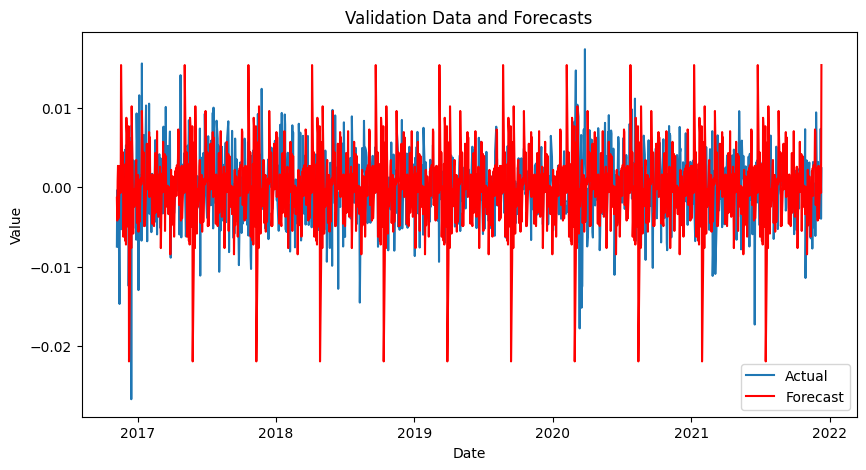

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 假设 validation_data['column_name'] 包含验证集的实际值
# validation_predictions 包含从ARIMA模型预测得到的预测值
validation_predictions = sarima_result_daily.forecast(steps=len(validation_data))

# 首先需要确保预测值是与实际值相对应的格式，如果预测值是pandas Series或DataFrame，可能需要进行适当转换
actuals = validation_data.values  # 获取实际值
predictions = validation_predictions.values  # 获取预测值

# 计算MSE
mse = mean_squared_error(actuals, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算MAE
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 可视化预测与实际数据
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(validation_data.index, actuals, label='Actual')
plt.plot(validation_data.index, predictions, label='Forecast', color='red')
plt.title('Validation Data and Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

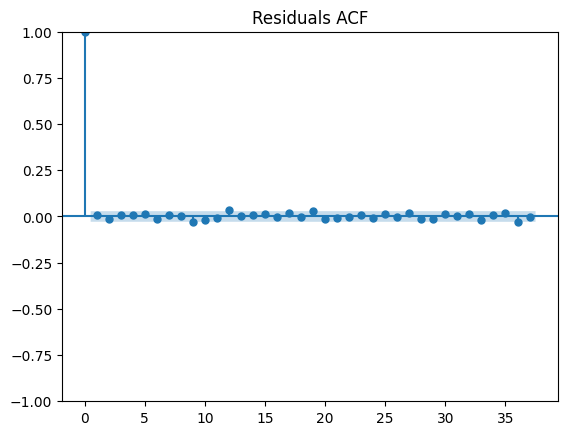

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# 拟合模型后获取残差
residuals2 = sarima_result_daily.resid

# 绘制残差的自相关图
plot_acf(residuals2)
plt.title('Residuals ACF')
plt.show()


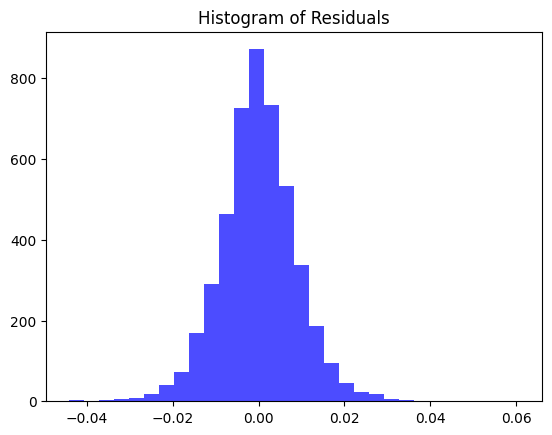

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 绘制残差的直方图
plt.hist(residuals2, bins=30, alpha=0.7, color='b')
plt.title('Histogram of Residuals')
plt.show()



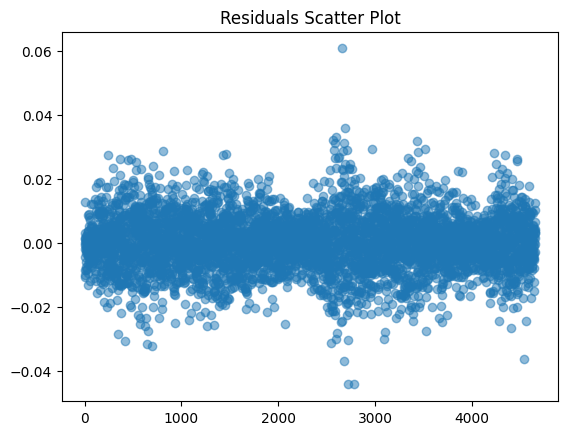

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS

# 绘制残差散点图
plt.scatter(x=np.arange(len(residuals2)), y=residuals2, alpha=0.5)
plt.title('Residuals Scatter Plot')
plt.show()

Mean Squared Error (MSE): 5.035553415036507e-05
Mean Absolute Error (MAE): 0.005417605954839832
Root Mean Squared Error (RMSE): 0.0070961633401694655


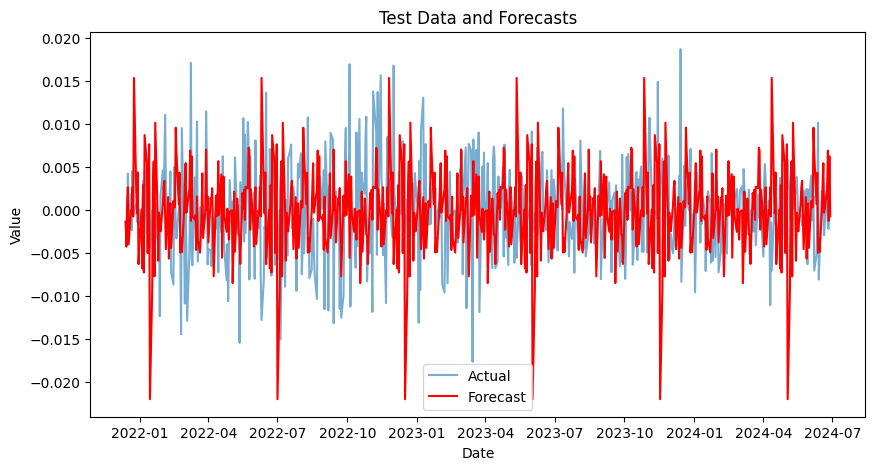

In [ ]:

test_predictions = sarima_result_daily.forecast(steps=len(test_data))

# 首先需要确保预测值是与实际值相对应的格式，如果预测值是pandas Series或DataFrame，可能需要进行适当转换
actuals = test_data.values  # 获取实际值
predictions = test_predictions.values  # 获取预测值

# 计算MSE
mse = mean_squared_error(actuals, predictions)
print("Mean Squared Error (MSE):", mse)

# 计算MAE
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# 计算RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 可视化预测与实际数据
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(test_data.index, actuals, label='Actual', alpha = 0.6)
plt.plot(test_data.index, predictions, label='Forecast', color='red')
plt.title('Test Data and Forecasts')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

#### 6.1.3 Conclusion
Given our objective of managing and predicting hotel booking volumes, the daily cycle model, due to its higher prediction accuracy, is more suitable for daily operations and short-term management decisions. Although the monthly cycle model theoretically fits better, it may not be accurate enough for practical forecasting applications, which could hinder effective booking management and resource planning.  
Preliminary tests of time series autocorrelation (ACF) and partial autocorrelation (PACF) show that most lags are not significant, and the parameters of the model mostly have high p-values, which indeed may indicate that there is no significance in the data. the autocorrelation. We can consider using machine learning models and other variables to predict the number of reservations or whether to cancel reservations.  

__The hypothesis that only time factor significantly affects booking quantity is rejected.__


__Daily Cycle Model (SARIMAX(0, 1, 0)x(0, 1, 0, 30)):__  
__AIC and BIC:__ Higher, indicating that the model may not be a very good fit for the data.  
__MSE and RMSE:__ Relatively lower (10628.771 and 103.096), indicating that the model has a high prediction accuracy for daily data.  
__Monthly Cycle Model (SARIMAX(1, 1, 1)x(1, 1, 1, 12)):__  
__AIC and BIC:__ Significantly lower, which usually means a better model fit.  
__MSE and RMSE:__ Significantly higher (1312665.261 and 1145.716), indicating that the model has a large prediction error for monthly data.  




# 9 Conclusions

This project focused on predicting hotel booking cancellations using machine learning models and time-series analysis to assist hotels in managing operations more effectively. We use a dataset with booking-related features and weather data to identify key patterns and factors influencing cancellations.

- Key Factors Affecting Booking Cancellations  
We analyzed various models to identify the key factors influencing booking cancellations. Through feature selection and model evaluations, we discovered that variables such as lead time, booking changes, and average daily rates played significant roles in determining the likelihood of cancellations. The important features vary across three different models: Decision Tree, Neural Network, and Logistic Regression. In the Decision Tree model, features such as the absence of a deposit requirement, changes in reserved rooms, and the total number of special requests play significant roles in predicting the cancellation. The Neural Network emphasizes features like bookings made for city hotels, changes in reserved rooms, and average daily rate (ADR), along with customer types and weather conditions. Meanwhile, Logistic Regression highlights the influence of previous cancellations, the requirement of car parking spaces, and the absence of a deposit requirement, with positive coefficients, while the Online TA market segment has a negative coefficient. By accurately identifying these factors, hotels can implement targeted strategies, such as offering incentives for longer stays or adjusting cancellation policies, to reduce the impact of cancellations.

- Predicting Daily Hotel Booking Volumes Using Time-Series Analysis  
To forecast hotel booking volumes and help optimize hotel strategy, we employed time-series analysis through SARIMA models on daily and monthly data. The analysis revealed consistent seasonal trends, enabling us to anticipate booking volumes with reasonable accuracy. AAlthough the monthly cycle model did not provide a better fit, we can consider incorporating machine learning models and other variables to predict the number of reservations or anticipate cancellations. The Time-Series model still offers a valuable approach for forecasting.

- Machine Learning Model Performance  
Among the machine learning models, the Neural Network model demonstrated strong predictive performance with high accuracy, recall, and F1 score. The Decision Tree model provided interpretability while achieving good accuracy, and Logistic Regression presented robust AUC scores. However, combining these models into an ensemble further improved prediction accuracy to 82.86% and other metrics. The ensemble approach aggregated the strengths of individual models, allowing the model to handle the complexities and nuances of the data effectively.

In conclusion, our predictive model provides practical insights for hotels to anticipate booking cancellations and manage daily booking volumes. By incorporating machine learning and time-series analysis, hotels can enhance operational efficiency and profitability. Future research could focus on refining these models with additional data sources and more advanced techniques to further improve prediction accuracy.

## References
__Dataset source__: https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-02-11


__Domain Knowledge__:  
Antonio, N., de Almeida, A., and Nunes, L. (2019). Hotel booking demand datasets: https://www.sciencedirect.com/science/article/pii/S2352340918315191  

- https://keras.io/api/layers/
- https://scikit-learn.org/stable/modules/ensemble.html
- https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf
- https://medium.com/ai-advances/boost-your-ml-models-performance-with-ensemble-modeling-9d0d5df8f307